In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics       import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error,r2_score

In [49]:
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

In [50]:
df = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view', skiprows=1, thousands='.', decimal=',')[0]


In [51]:
df = df.rename(columns={0:'Date',1:'Price'})
df.isnull().sum()

Date     0
Price    0
dtype: int64

In [52]:
df['Date'] = df['Date'].str.replace('/', '-')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [53]:
date_min = df['Date'].min()
date_max = df['Date'].max()

In [54]:
df.to_excel('data.xlsx')

In [55]:
df.head()

,Date,Price
0,2024-05-13,83.18
1,2024-05-10,83.39
2,2024-05-09,83.27
3,2024-05-08,82.44
4,2024-05-07,82.69


In [56]:
# Definindo a coluna 'A' como o índice
df = df.set_index('Date')

In [57]:
df.head()

,Price
Date,
2024-05-13,83.18
2024-05-10,83.39
2024-05-09,83.27
2024-05-08,82.44
2024-05-07,82.69


<Axes: xlabel='Date'>

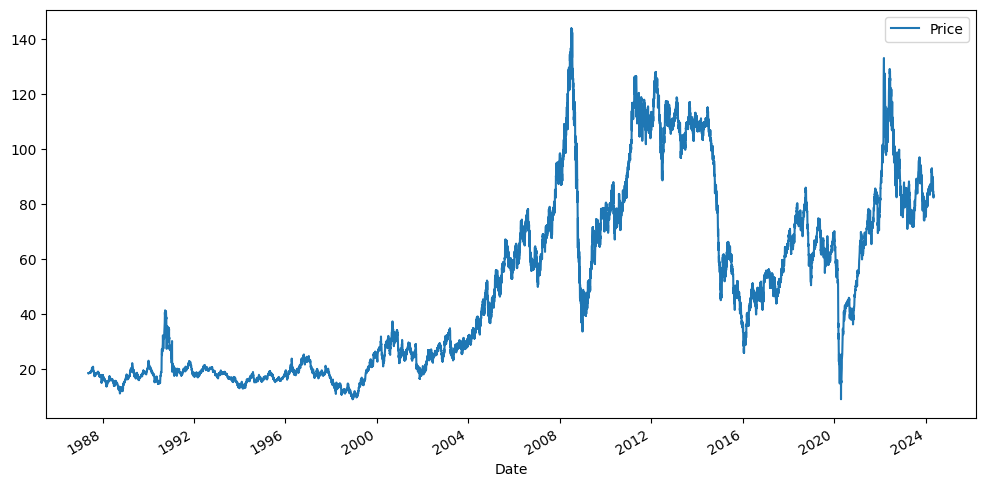

In [58]:
df.plot(figsize=(12,6))

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

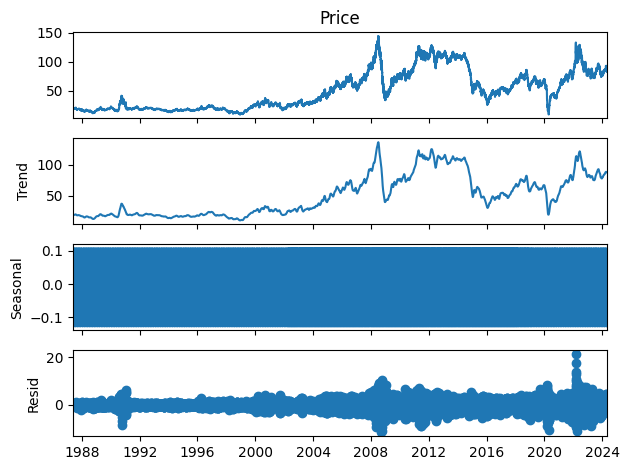

In [60]:
# Ordenando o índice de data em ordem crescente
df = df.sort_index()

results = seasonal_decompose(df['Price'],period=30)
results.plot();

In [61]:
# Filtrar o DataFrame para datas a partir de 01/01/2014
df = df.loc['2020-01-01':]

In [62]:
# Create additional features using the datetime index
#df['Day_of_week'] = df.index.dayofweek
#df['Month'] = df.index.month
#df['Year'] = df.index.year

df.head()

,Price
Date,
2020-01-02,67.05
2020-01-03,69.08
2020-01-06,70.25
2020-01-07,68.74
2020-01-08,67.31


In [63]:
len(df)

1110

In [64]:
train = df.iloc[:1091]
test = df.iloc[1091:]

In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [66]:
df.head(),df.tail()

(            Price
 Date             
 2020-01-02  67.05
 2020-01-03  69.08
 2020-01-06  70.25
 2020-01-07  68.74
 2020-01-08  67.31,
             Price
 Date             
 2024-05-07  82.69
 2024-05-08  82.44
 2024-05-09  83.27
 2024-05-10  83.39
 2024-05-13  83.18)

In [67]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaler.fit(test)
scaled_test = scaler.transform(test)

In [68]:
scaled_train[:10]

array([[0.46695148],
       [0.48331453],
       [0.49274545],
       [0.48057392],
       [0.46904724],
       [0.46316299],
       [0.4646945 ],
       [0.44349508],
       [0.44599387],
       [0.43664356]])

In [70]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [71]:
# define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [72]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.46695148 0.48331453 0.49274545 0.48057392 0.46904724]
Predict this y: 
 [[0.46316299]]


In [73]:
X.shape

(1, 5, 1)

In [74]:
# We do the same thing, but now instead for 12 months
n_input = 5
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [75]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [76]:
# Crie o modelo
#model = Sequential()
#model.add(LSTM(90, activation='sigmoid', input_shape=(n_input, n_features)))
#model.add(Dense(1))  # Mantenha a camada de saída
#model.compile(optimizer='adam', loss='mse')

In [77]:
# define model
model = Sequential()
model.add(LSTM(80, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

c:\Users\flade\Documents\GitHub\TECH3_PETROLEO\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [78]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80)             │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,321 (102.82 KB)

 Trainable params: 26,321 (102.82 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
  73/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1887

c:\Users\flade\Documents\GitHub\TECH3_PETROLEO\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1086/1086 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0301
Epoch 2/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.5597e-04
Epoch 3/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0011
Epoch 4/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.4901e-04
Epoch 5/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.7693e-04
Epoch 6/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.8006e-04
Epoch 7/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.1964e-04
Epoch 8/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1327e-04
Epoch 9/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9681e-04
Epoch 10/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.9774e-04
Epoch 11/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.6797e-04
Epoch 12/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.9417e-04
Epoch 13/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.8417e-04
Epoch 14/50
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.8

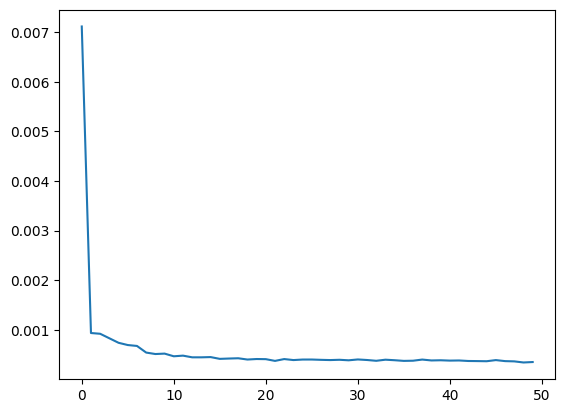

In [80]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [81]:
last_train_batch = scaled_train[-n_input:]

In [82]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [83]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


array([[0.6553305]], dtype=float32)

In [84]:
scaled_test[0]

array([1.])

In [85]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [86]:
test_predictions

[array([0.6553305], dtype=float32),
 array([0.6547806], dtype=float32),
 array([0.6541464], dtype=float32),
 array([0.6532034], dtype=float32),
 array([0.65189797], dtype=float32),
 array([0.6505616], dtype=float32),
 array([0.64927346], dtype=float32),
 array([0.6480162], dtype=float32),
 array([0.6467704], dtype=float32),
 array([0.6455278], dtype=float32),
 array([0.6442886], dtype=float32),
 array([0.64305437], dtype=float32),
 array([0.64182574], dtype=float32),
 array([0.6406026], dtype=float32),
 array([0.63938457], dtype=float32),
 array([0.6381715], dtype=float32),
 array([0.6369632], dtype=float32),
 array([0.6357596], dtype=float32),
 array([0.6345606], dtype=float32)]

In [87]:
test.head(14)

,Price
Date,
2024-04-16,91.29
2024-04-17,89.54
2024-04-18,88.34
2024-04-19,87.96
2024-04-22,87.30
2024-04-23,88.29
2024-04-24,89.02
2024-04-25,88.10
2024-04-26,89.95


In [88]:
true_predictions = scaler.inverse_transform(test_predictions)

In [89]:
test['Predictions'] = true_predictions

C:\Users\flade\AppData\Local\Temp\ipykernel_26484\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

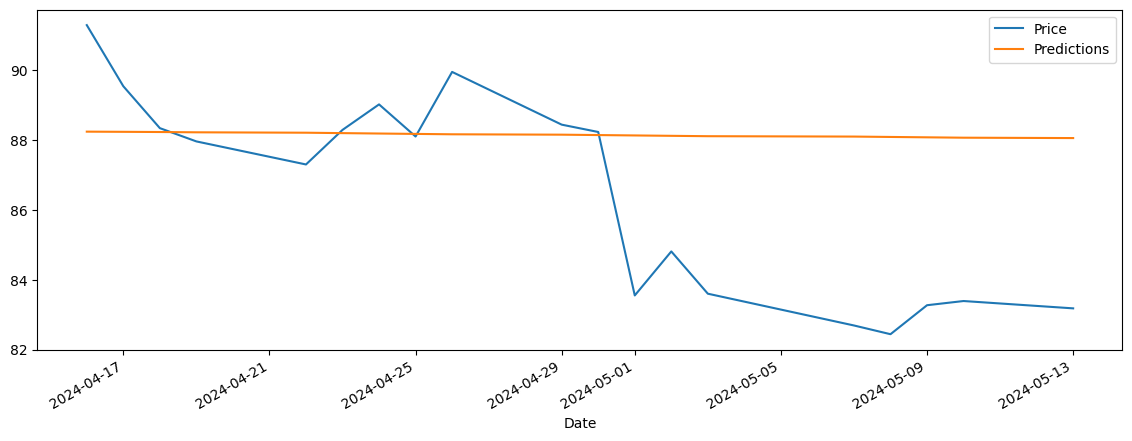

In [90]:
test.plot(figsize=(14,5))

In [91]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Price'],test['Predictions']))
print(rmse)

3.2288522595794964


In [92]:
test.head()

,Price,Predictions
Date,,
2024-04-16,91.29,88.239675
2024-04-17,89.54,88.234809
2024-04-18,88.34,88.229195
2024-04-19,87.96,88.220850
2024-04-22,87.30,88.209297


In [93]:
# performance com 90 dias a partir de 2022> mae 3,27 mape 0,03 rmse 3,67
# performance com 10 dias a partir de 2020> mae 1,47 mape 0,017 rmse 1,90
# performance com 5 dias a partir de 2020> mae 2,19 mape 0,025 rmse 3,03
# parametros 
#model = Sequential()
#model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')

In [94]:

lstm_performance = ml_error( "LSTM PERFORMANCE", test['Price'],test['Predictions'] )
lstm_performance

,Model Name,MAE,MAPE,RMSE
0,LSTM PERFORMANCE,2.453444,0.02906,3.228852
